In [1]:
import os
os.chdir("../")

import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
from PIL import Image
matplotlib.get_cachedir()
plt.rc('font', family="Times New Roman")

# https://github.com/facebookresearch/ImageBind
# from imagebind import data
# from imagebind.data import waveform2melspec, get_clip_timepoints
# import torch
# from imagebind.models import imagebind_model
# from imagebind.models.imagebind_model import ModalityType

from utils import vggsound_template, vggsound_classes
from languagebind import LanguageBind, to_device, transform_dict, LanguageBindImageTokenizer

from sklearn import metrics

import torch
from torchvision import transforms

import torchaudio
from pytorchvideo.data.clip_sampling import ConstantClipsPerVideoSampler

/home/cry/anaconda3/envs/languagebind/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cry/anaconda3/envs/languagebind/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/cry/anaconda3/envs/languagebind/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [3]:
clip_sampler = ConstantClipsPerVideoSampler(
    clip_duration=2, clips_per_video=3
)

In [2]:
def imshow(img):
    """
    Visualizing images inside jupyter notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

def denormalize(tensor, mean, std):
    """
    对归一化后的张量进行反归一化处理。
    
    参数:
    tensor: 归一化后的张量
    mean: 均值
    std: 标准差
    
    返回:
    反归一化后的张量
    """
    return tensor * std + mean

def convert_mfcc(spectrogram, mean= -4.268, std= 9.138, channel = 0):
    # 确保输入的频谱图有 3 个通道
    assert spectrogram.shape[0] == 3, "Spectrogram must have 3 channels."
    
    spectrogram = spectrogram[channel, 0, :, :]
    
    denormalized_tensor = denormalize(spectrogram, mean, std)
    
    return denormalized_tensor

In [3]:
def read_audio(
    audio_path,
    device,
    num_mel_bins=128,
    target_length=204,
    sample_rate=16000,
    mean= -4.268, 
    std= 9.138
):
    waveform, sr = torchaudio.load(audio_path)
    if sample_rate != sr:
        waveform = torchaudio.functional.resample(
            waveform, orig_freq=sr, new_freq=sample_rate
        )
    all_clips_timepoints = get_clip_timepoints(
        clip_sampler, waveform.size(1) / sample_rate
    )
    all_clips = []
    for clip_timepoints in all_clips_timepoints:
        waveform_clip = waveform[
            :,
            int(clip_timepoints[0] * sample_rate) : int(
                clip_timepoints[1] * sample_rate
            ),
        ]
        waveform_melspec = waveform2melspec(
            waveform_clip, sample_rate, num_mel_bins, target_length
        )
        all_clips.append(waveform_melspec)

    normalize = transforms.Normalize(mean=mean, std=std)
    all_clips = [normalize(ac).to(device) for ac in all_clips]

    all_clips = torch.stack(all_clips, dim=0)
    return all_clips.cpu().numpy()

In [4]:
def visualization(image, submodular_image_set, saved_json_file, index=None):
    insertion_ours_images = []
    deletion_ours_images = []

    insertion_image = submodular_image_set[0] - submodular_image_set[0]
    insertion_ours_images.append(insertion_image)
    deletion_ours_images.append(image - insertion_image)
    for smdl_sub_mask in submodular_image_set[:]:
        insertion_image = insertion_image.copy() + smdl_sub_mask
        insertion_ours_images.append(insertion_image)
        deletion_ours_images.append(image - insertion_image)

    insertion_ours_images_input_results = np.array([saved_json_file["baseline_score"]] + saved_json_file["consistency_score"])

    if index == None:
        ours_best_index = np.argmax(insertion_ours_images_input_results)
    else:
        ours_best_index = index
    x = [j/len(saved_json_file["consistency_score"]) for j in range(len(saved_json_file["consistency_score"])+1)]
    i = len(x)

    fig = plt.figure(figsize=(24,8))
    # fig, [ax2, ax3] = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 1.5]}, figsize=(24,8))
    gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1.5])
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_title('Spectrogram Attribution', fontsize=54)
    ax1.set_facecolor('white')
    
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    # ax2.set_title('Ours', fontsize=54)
    ax2.set_facecolor('white')
    
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.spines["left"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["bottom"].set_visible(False)
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    # ax3.set_title('Ours', fontsize=54)
    ax3.set_facecolor('white')

    ax4 = fig.add_subplot(gs[:, 1])
    ax4.set_xlim((0, 1))
    ax4.set_ylim((0, 1.02))
    ax4.set_title('Insertion', fontsize=54)
    ax4.set_ylabel('Recognition Score', fontsize=44)
    ax4.set_xlabel('Percentage of image revealed', fontsize=44)
    ax4.tick_params(axis='both', which='major', labelsize=36)

    x_ = x[:i]
    print(x_)
    ours_y = insertion_ours_images_input_results[:i]
    ax4.plot(x_, ours_y, color='mediumseagreen', linewidth=3.5)  # draw curve
    ax4.set_facecolor('white')
    ax4.spines['bottom'].set_color('black')
    ax4.spines['bottom'].set_linewidth(2.0)
    ax4.spines['top'].set_color('none')
    ax4.spines['left'].set_color('black')
    ax4.spines['left'].set_linewidth(2.0)
    ax4.spines['right'].set_color('none')

    # plt.legend(["Ours"], fontsize=40, loc="upper left")
    ax4.scatter(x_[-1], ours_y[-1], color='mediumseagreen', s=54)  # Plot latest point
    # 在曲线下方填充淡蓝色
    ax4.fill_between(x_, ours_y, color='mediumseagreen', alpha=0.1)

    ax4.axvline(x=x_[ours_best_index], color='red', linewidth=3.5)  # 绘制红色垂直线

    # Ours
    ax1.imshow(convert_mfcc(insertion_ours_images[ours_best_index], channel = 0), aspect='auto', origin='lower', cmap='viridis')
    
    ax2.imshow(convert_mfcc(insertion_ours_images[ours_best_index], channel = 1), aspect='auto', origin='lower', cmap='viridis')
    
    ax3.imshow(convert_mfcc(insertion_ours_images[ours_best_index], channel = 1), aspect='auto', origin='lower', cmap='viridis')

    auc = metrics.auc(x, insertion_ours_images_input_results)

    print("Highest confidence: {}\nfinal confidence: {}\nInsertion AUC: {}".format(insertion_ours_images_input_results.max(), insertion_ours_images_input_results[-1], auc))
    
def gen_cam(image_path, mask):
    """
    Generate heatmap
        :param image: [H,W,C]
        :param mask: [H,W],range 0-1
        :return: tuple(cam,heatmap)
    """
    # Read image
    image = cv2.resize(cv2.imread(image_path), (224,224))
    # mask->heatmap
    heatmap = cv2.applyColorMap(np.uint8(mask), cv2.COLORMAP_COOL)
    heatmap = np.float32(heatmap)

    # merge heatmap to original image
    cam = 0.5*heatmap + 0.5*np.float32(image)
    return cam, (heatmap).astype(np.uint8)

def norm_image(image):
    """
    Normalization image
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)

In [8]:
audio_name = "gklbB7TYoK4_000030"
label = 10
print(vggsound_classes[label])
audio_path = "/home/cry/J-16/Datasets/vggsound/audio/test/{}.flac".format(audio_name)
audio_input = read_audio(audio_path, "cpu")

json_path = "/home/cry/H6-K/SMDL-Attribution/submodular_results/vggsound-imagebind-efficientv2-debug/sound-0.01-0.05-20.0-5.0-pending-samples-20-divison-10/json/{}/{}.json".format(label, audio_name)
npy_path = "/home/cry/H6-K/SMDL-Attribution/submodular_results/vggsound-imagebind-efficientv2-debug/sound-0.01-0.05-20.0-5.0-pending-samples-20-divison-10/npy/{}/{}.npy".format(label, audio_name)

submodular_image_set = np.load(npy_path)
with open(json_path, 'r', encoding='utf-8') as f:
    saved_json_file = json.load(f)

baby laughter


In [11]:
vggsound_classes[140]

'people belly laughing'

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
Highest confidence: 0.9957980513572693
final confidence: 0.02304830215871334
Insertion AUC: 0.3236118650732318


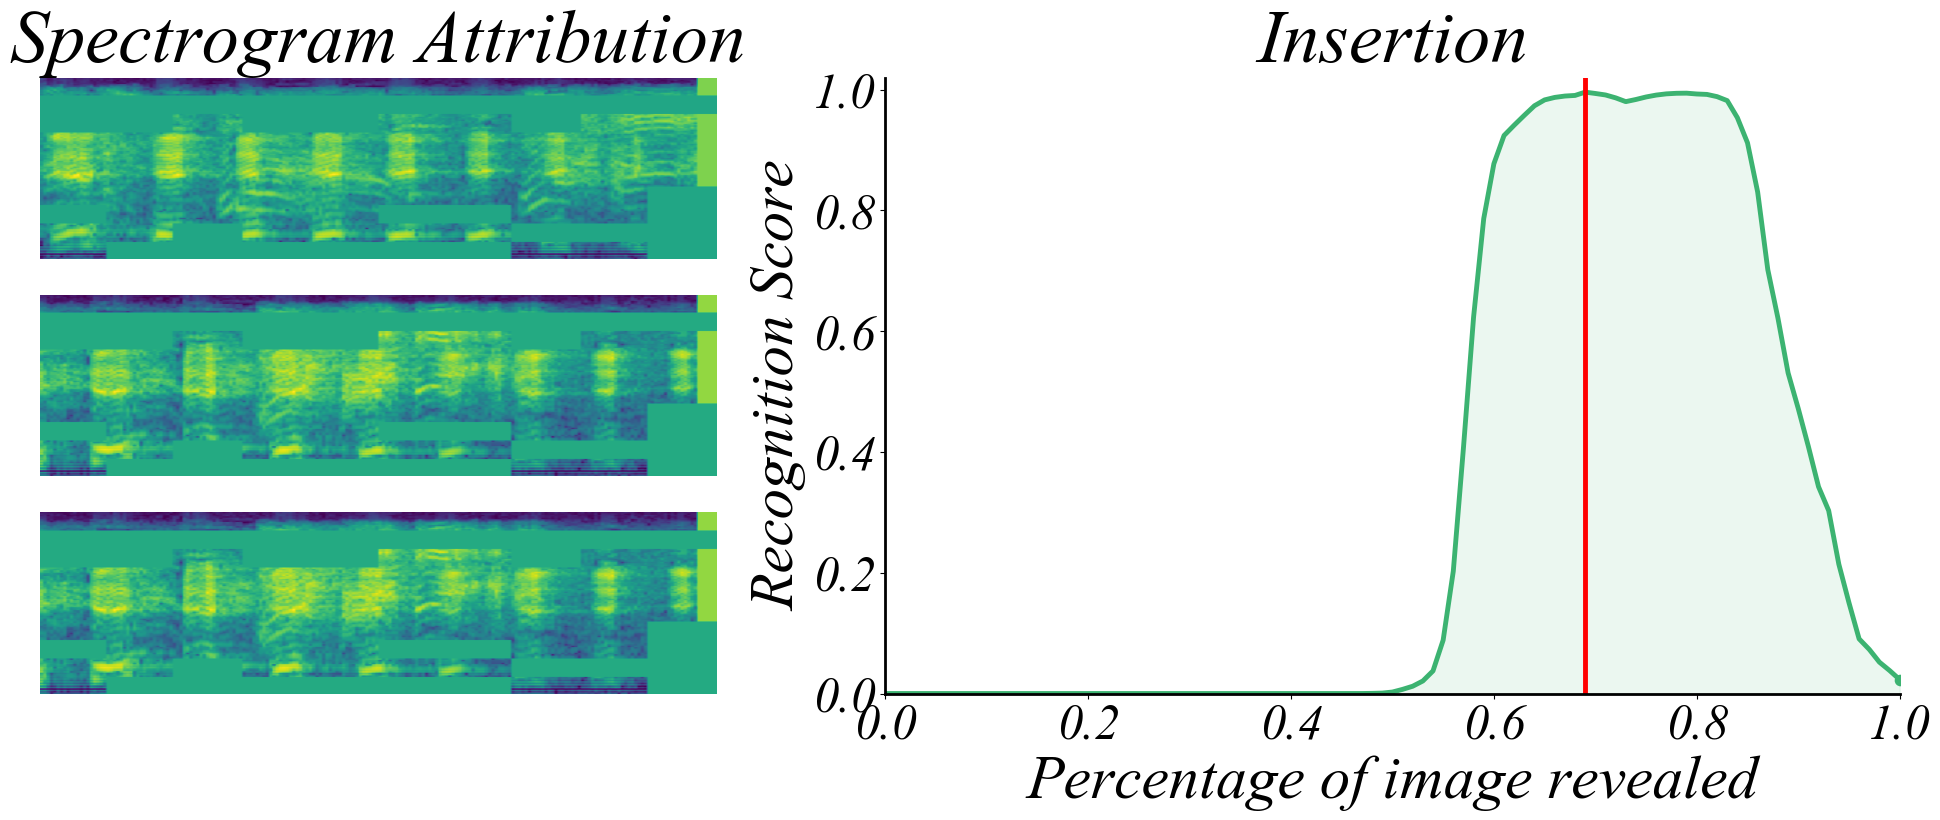

In [10]:
visualization(audio_input, submodular_image_set, saved_json_file)

In [5]:
clip_type = {
        'audio': 'LanguageBind_Audio_FT',  # also LanguageBind_Audio
    }

model = LanguageBind(clip_type=clip_type, cache_dir='.checkpoints')

/home/cry/anaconda3/envs/languagebind/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
def read_audio(
    audio_path,
    modality_transform,
    device = "cpu"
):
    audio = [audio_path]
    audio_proccess = to_device(modality_transform['audio'](audio), device)['pixel_values'][0]
    return audio_proccess.cpu().numpy()



modality_transform = {c: transform_dict[c](model.modality_config[c]) for c in clip_type.keys()}

In [7]:
audio_name = "8wT5dihdt4E_000260"
label = 44
print(vggsound_classes[label])
audio_path = "/home/cry/J-16/Datasets/vggsound/audio/test/{}.flac".format(audio_name)
audio_input = read_audio(audio_path, modality_transform, "cpu")

json_path = "/home/cry/H6-K/SMDL-Attribution/submodular_results/vggsound-languagebind-efficientv2-debug/sound-0.01-0.05-20.0-5.0-pending-samples-20-divison-10/json/{}/{}.json".format(label, audio_name)
npy_path = "/home/cry/H6-K/SMDL-Attribution/submodular_results/vggsound-languagebind-efficientv2-debug/sound-0.01-0.05-20.0-5.0-pending-samples-20-divison-10/npy/{}/{}.npy".format(label, audio_name)

submodular_image_set = np.load(npy_path)
submodular_image_set = submodular_image_set[:,:,np.newaxis,:,:]
with open(json_path, 'r', encoding='utf-8') as f:
    saved_json_file = json.load(f)

child speech, kid speaking


In [10]:
vggsound_classes[45]

'children shouting'

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
Highest confidence: 0.8659791350364685
final confidence: 0.07327926903963089
Insertion AUC: 0.5748598373689492


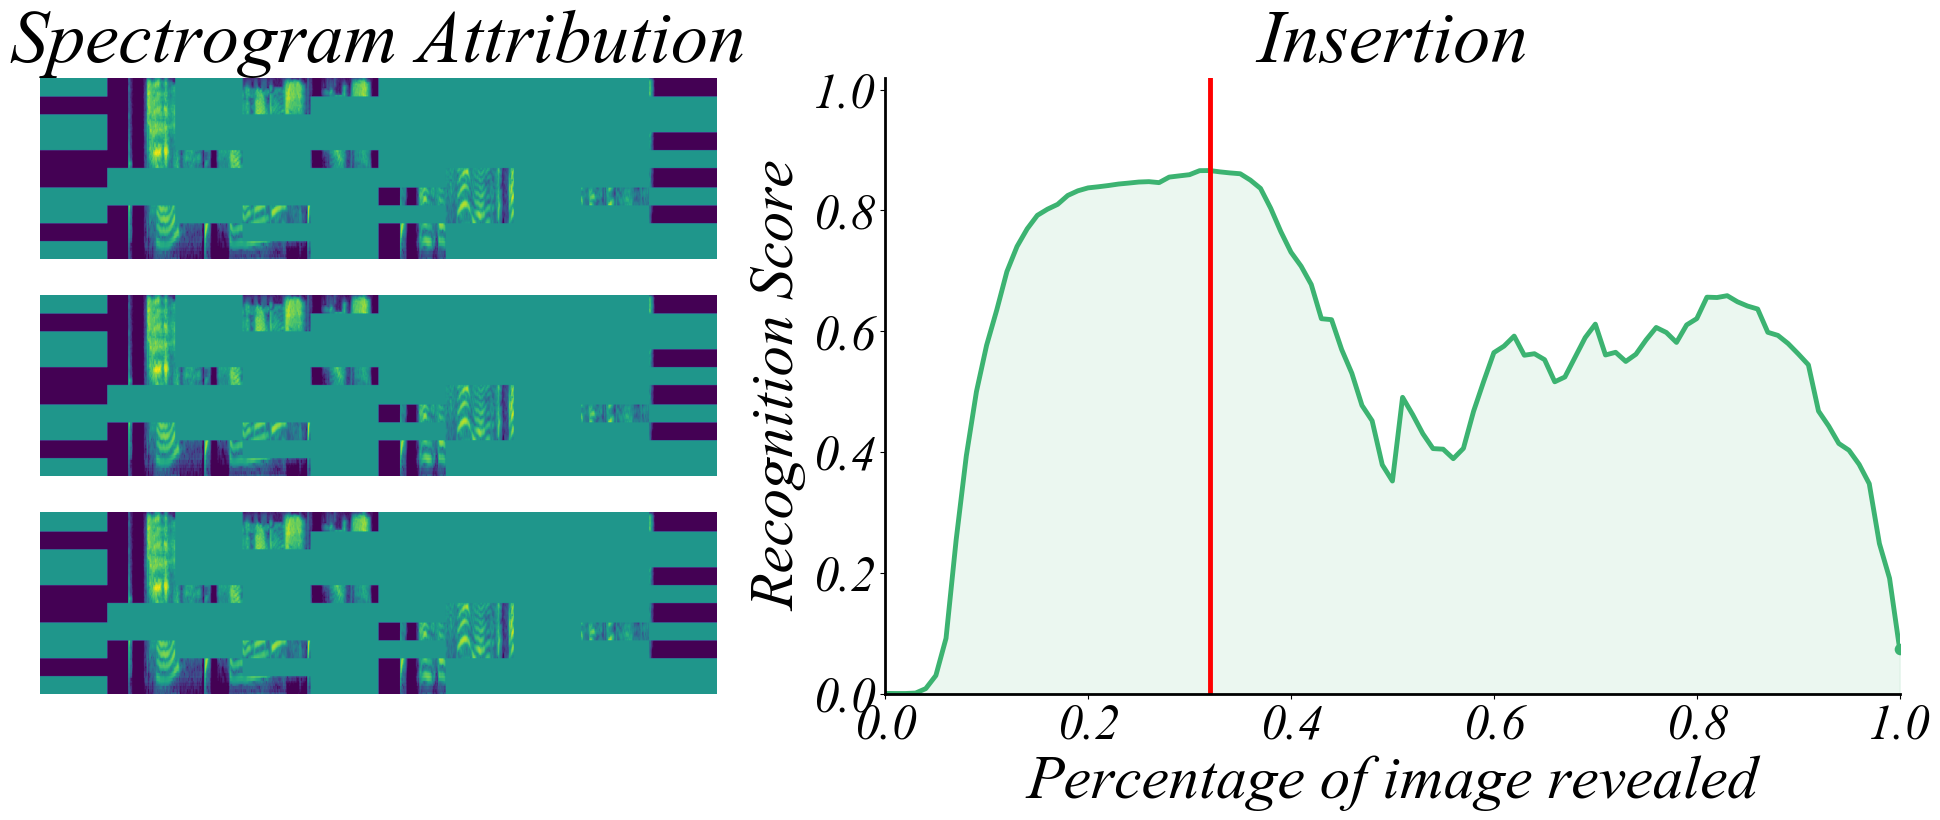

In [9]:
visualization(audio_input, submodular_image_set, saved_json_file)